In [1]:
import os
import sys
import time
import argparse
import random

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score

from torch.distributions.binomial import Binomial
from torch.distributions.bernoulli import Bernoulli
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import DataCollatorForLanguageModeling, BertForMaskedLM, BertModel
from transformers import Trainer, TrainingArguments
from transformers import get_linear_schedule_with_warmup, AdamW

from tokens import WordLevelBertTokenizer
from vocab import create_vocab
from data import CausalBertRealDataset
from utils import DATA_PATH, make_dirs
from causal_bert_real import CausalBOW, CausalBert, load_data, est_casual_effect
from causal_tokens import *

In [2]:
FLU_TOKENS

['diag:A492', 'diag:B963', 'diag:J09', 'diag:J10', 'diag:J11']

In [2]:
def true_casual_effect(data_loader, effect='ate', estimation='q'):
    assert estimation == 'q', f'unallowed estimation: {estimation}'
    
    dataset = data_loader.dataset
    
    Q1 = dataset.treatment * dataset.response + (1 - dataset.treatment) * dataset.pseudo_response
    Q1 = Q1.cpu().data.numpy().squeeze()

    Q0 = dataset.treatment * dataset.pseudo_response + (1 - dataset.treatment) * dataset.response
    Q0 = Q0.cpu().data.numpy().squeeze()

    treatment = dataset.treatment.cpu().data.numpy().squeeze()
    prop_scores = dataset.prop_scores.cpu().data.numpy().squeeze()
    
    if estimation == 'q':
        if effect == 'att':
            phi = (treatment * (Q1 - Q0))
            return phi.sum() / treatment.sum()
        elif effect == 'ate':
            return (Q1 - Q0).mean()
        
    elif estimation == 'plugin':
        phi = (prop_scores * (Q1 - Q0)).mean()
        if effect == 'att':
            return phi / treatment.mean()
        elif effect == 'ate': 
            return phi

In [4]:
trained = '/nfs/turbo/lsa-regier/bert-results/results/casualmodel/realdata/[BEST]_[flu-asthma]_C-BERT_64_20.pth'

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '5'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
model = torch.load(trained).to(device)

In [6]:
pretreat_tokens = None
treat_tokens = FLU_TOKENS
response_tokens = ASTHMA_TOKENS

train_loader, test_loader = load_data(pretreat_tokens, treat_tokens, response_tokens, 16, device=device)

unadjust = (test_loader.dataset.responses[test_loader.dataset.treatments == 1].mean() - 
            test_loader.dataset.responses[test_loader.dataset.treatments == 0].mean()).item()
print(f'Unadjusted: [value: {unadjust:.4f}]')

Load training set in 107.06 sec
Training set: [treated: 0.0640], Training set: [response: 0.0752]
Load validation set in 91.45 sec
Validation set: [treated: 0.0641], Validation set: [response: 0.0754]
****************************************************************************************************
Unadjusted: [value: 0.0268]


In [7]:
prop_scores = []

treatments = []
responses = []

tokens = []
model.eval()
for idx, (token, treatment, response) in enumerate(test_loader):
    prop_score, _, _ = model(token)
    if model.prop_is_logit:
        sigmoid = nn.Sigmoid()
        prop_score = sigmoid(prop_score)
    prop_scores.append(prop_score.cpu().data.numpy().squeeze())
    treatments.append(treatment.cpu().data.numpy().squeeze())
    responses.append(response.cpu().data.numpy().squeeze())
    tokens.append(token.cpu().data.numpy().squeeze())
    
prop_scores = np.concatenate(prop_scores, axis=0)
treatments = np.concatenate(treatments, axis=0)
responses = np.concatenate(responses, axis=0)
tokens = np.concatenate(tokens, axis=0)

In [8]:
w_ate = treatments / prop_scores + (1 - treatments) / (1 - prop_scores)
w_att = treatments + (1 - treatments) * prop_scores / (1 - prop_scores)

In [53]:
def est_effect(responses, treatments, prop_scores, est, outlier=None):
    
    if outlier:
        responses = responses[(prop_scores > outlier) & (prop_scores < 1 - outlier)]
        treatments = treatments[(prop_scores > outlier) & (prop_scores < 1 - outlier)]
        prop_scores = prop_scores[(prop_scores > outlier) & (prop_scores < 1 - outlier)]

    w_ate = treatments / prop_scores + (1 - treatments) / (1 - prop_scores)
    w_att = treatments + (1 - treatments) * prop_scores / (1 - prop_scores)

    if est == 'ate':
        w = w_ate
    else:
        w = w_att
    e1 = (responses * treatments * w).sum() / (treatments * w).sum()
    e2 = (responses * (1 - treatments) * w).sum() / ((1 - treatments) * w).sum()

    return e1 - e2

In [48]:
responses[treatments == 1].mean() - responses[treatments == 0].mean()

0.026797377

In [54]:
est_effect(responses, treatments, prop_scores, 'ate')

-0.06915057

In [55]:
est_effect(responses, treatments, prop_scores, 'att')

-0.12588689

In [41]:
roc_auc_score(treatments, prop_scores)

0.9996650738715093

In [14]:
treatments.shape

(191760,)

In [15]:
treatments.sum()

12285.0

In [16]:
responses.sum()

14468.0

Text(0, 0.5, 'Predicted propensity scores')

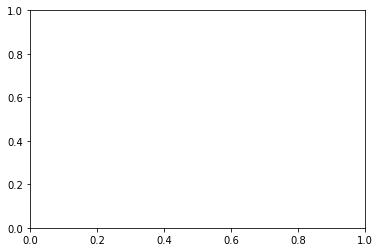

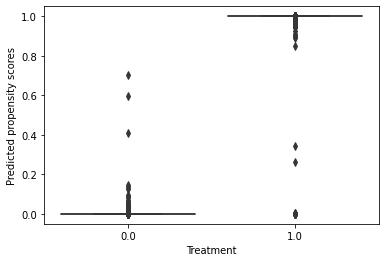

In [17]:
dat = np.array([treatments, prop_scores]).T
dat = pd.DataFrame(dat, columns=['treatments', 'pred_prop_scores'])

plt.cla()
fig = plt.figure()
ax = fig.add_subplot(111)
_ = sns.boxplot(y='pred_prop_scores', x='treatments', data=dat, palette="colorblind", )
ax.set_xlabel('Treatment')
ax.set_ylabel('Predicted propensity scores')

In [18]:
prop_scores[treatments == 0].max()

0.89336056

In [19]:
prop_scores[treatments == 0].min()

9.1526886e-07